## Predict Future Sales

Final project for "How to win a data science competition" Coursera course

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Exercise 1: Download the data

In [3]:
#Categories
df_cat = pd.read_csv('data/categories.csv')
df_cat.head()

,category_name,category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4


In [15]:
#Categories
df_item = pd.read_csv('data/items.csv')
df_item.head()

,item_id,category_id,item_name
0,0,40,!! IN THE POWER OF HAPPINESS (PLAST) D
1,1,76,! ABBYY FineReader 12 Professional Edition Ful...
2,2,40,*** IN THE GLORY OF THE GLORY (UNV) D
3,3,40,*** BLUE WAVE (Univ) D
4,4,40,*** BOX (GLASS) D


In [16]:
#Shop
df_shop=pd.read_csv('data/shops.csv')
df_shop.head()

,shop_name,shop_id
0,"! Yakutsk Ordzhonikidze, 56 francs",0
1,"! Yakutsk TC ""Central"" fran",1
2,"Adygea TC ""Mega""",2
3,"Balashikha TC ""Oktyabr-Kinomir""",3
4,"Volga TC ""Volga Mall""",4


In [17]:
# Train Sales Data
df=pd.read_csv('data/sales_train.csv')
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [18]:
# Test Sales Data
df_t=pd.read_csv('data/test.csv',index_col="ID")
df_t.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [19]:
sub   = pd.read_csv("data/sample_submission.csv", index_col="ID")
sub.head()

,item_cnt_month
ID,
0,0.5
1,0.5
2,0.5
3,0.5
4,0.5


**EDA**

In [20]:
print(len(df), len(df_t))

2935849 214200


In [21]:
df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [22]:
# the length of the data
print(len(df_shop), len(df_cat))

60 84


Missing Values

In [23]:
#is there any null or missing data points
df.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

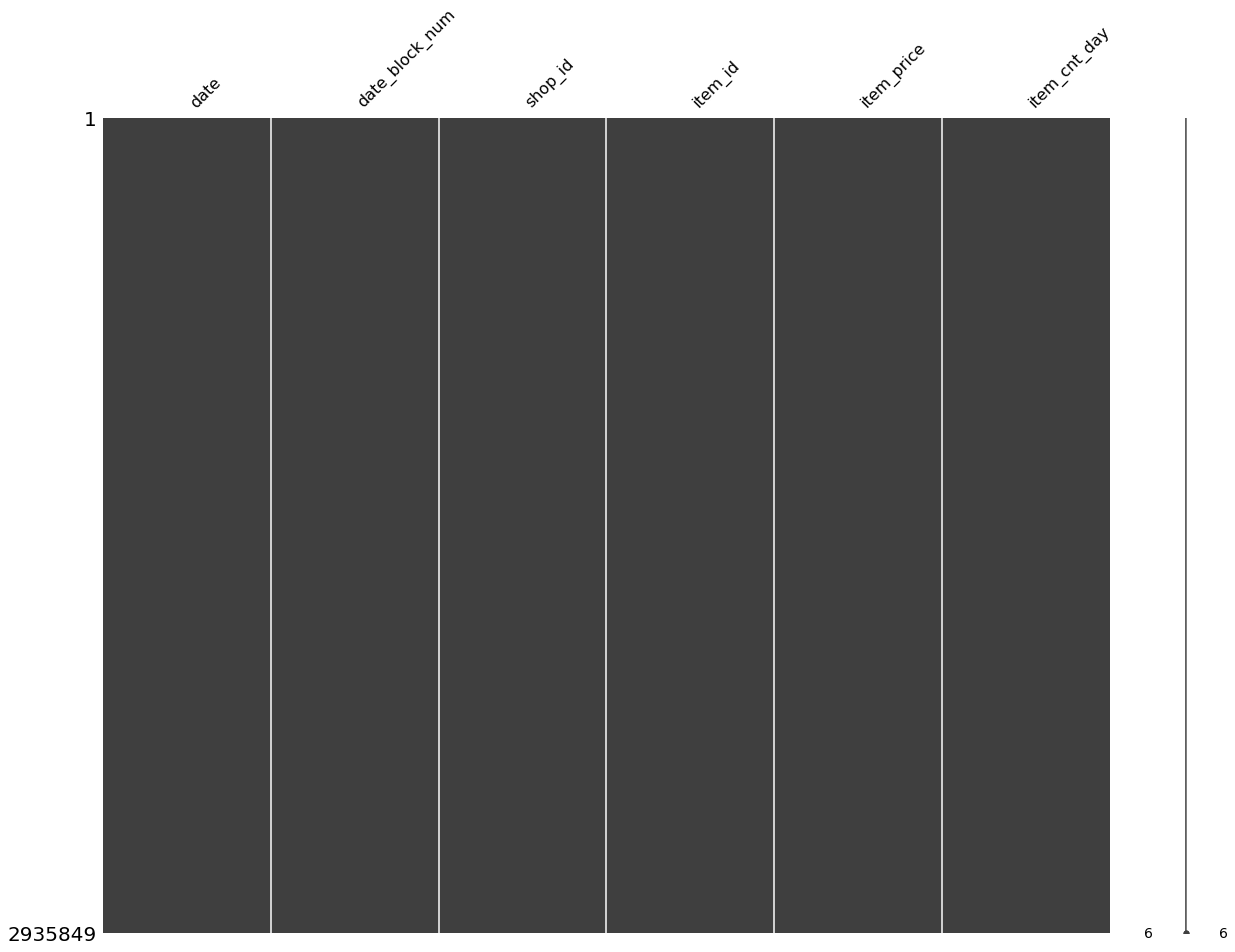

In [24]:
import missingno
missingno.matrix(df, figsize = (20,15))
plt.show()

In [34]:
import datetime as dt

# Change the date type
date = df.date.apply(lambda x:dt.datetime.strptime(x, '%d.%m.%Y'))

# Create 3 new features for year, month and day
df['year'] = date.dt.year
df['month'] = date.dt.month
df['day'] = date.dt.day
df.head()

# Remove the "date" feature
df = df.drop('date', axis=1)
df

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day
0,0,59,22154,999.00,1.0,2013,1,2
1,0,25,2552,899.00,1.0,2013,1,3
2,0,25,2552,899.00,-1.0,2013,1,5
3,0,25,2554,1709.05,1.0,2013,1,6
4,0,25,2555,1099.00,1.0,2013,1,15
...,...,...,...,...,...,...,...,...
2935844,33,25,7409,299.00,1.0,2015,10,10
2935845,33,25,7460,299.00,1.0,2015,10,9
2935846,33,25,7459,349.00,1.0,2015,10,14
2935847,33,25,7440,299.00,1.0,2015,10,22


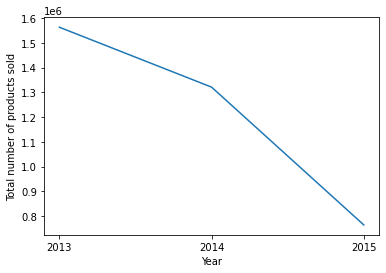

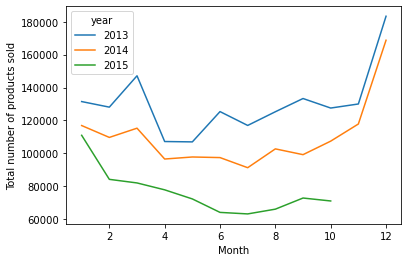

In [32]:
# Plot the total number of products sold by year
df.groupby('year').item_cnt_day.sum().plot()
plt.xticks(np.arange(2013, 2016, 1))
plt.xlabel('Year')
plt.ylabel('Total number of products sold')
plt.show()

# Plot the total number of products sold by month for each year
df.groupby(['month','year']).sum()['item_cnt_day'].unstack().plot()
plt.xlabel('Month')
plt.ylabel('Total number of products sold')
plt.show()

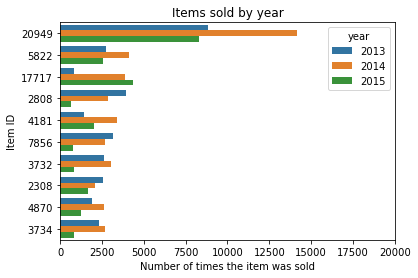

In [37]:
# Top 10 sold items
sns.countplot(y='item_id', hue='year', data=df, order = df['item_id'].value_counts().iloc[:10].index)
plt.xlim(0,20000)
plt.xlabel('Number of times the item was sold')
plt.ylabel('Item ID')
plt.title('Items sold by year')
plt.show()

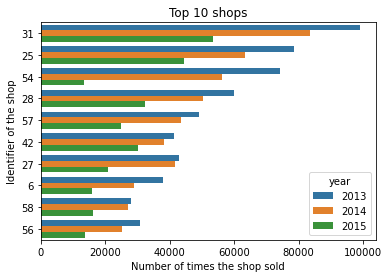

In [39]:
# Top 10 shops
sns.countplot(y='shop_id', hue='year', data=df, order = df['shop_id'].value_counts().iloc[:10].index)
plt.xlabel('Number of times the shop sold')
plt.ylabel('Identifier of the shop')
plt.title('Top 10 shops')
plt.show()

Columns names

In [30]:
df.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

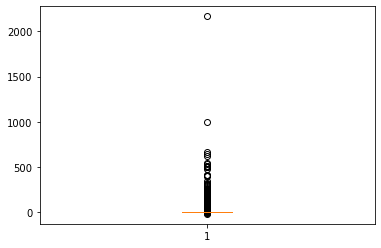

In [31]:
plt.boxplot(x=df.item_cnt_day)
plt.show()

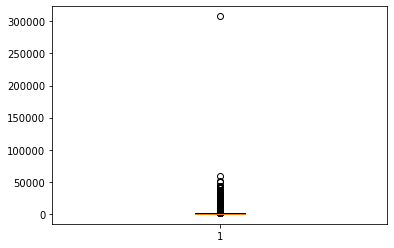

In [32]:
plt.boxplot(x=df.item_price)
plt.show()

Correlation heatmap

<AxesSubplot:>

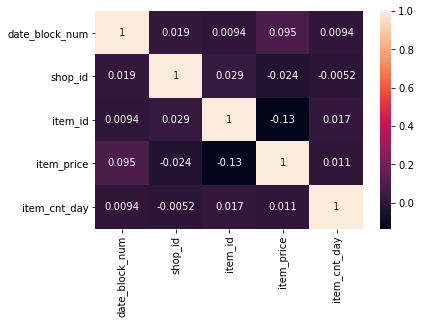

In [33]:
sns.heatmap(df.corr(),annot=True)

**November 2015 Sales**

In [42]:
df.tail() # October months 33 

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


In [43]:
oct_15=df[df.date_block_num==33]
oct_15.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2882335,23.10.2015,33,45,13315,649.0,1.0
2882336,05.10.2015,33,45,13880,229.0,1.0
2882337,02.10.2015,33,45,13881,659.0,1.0
2882338,12.10.2015,33,45,13881,659.0,1.0
2882339,04.10.2015,33,45,13923,169.0,1.0


Unique values:

In [44]:
oct_15.nunique() # 44 different shoppers and 5413 different items sold

date                31
date_block_num       1
shop_id             44
item_id           5413
item_price        1245
item_cnt_day        55
dtype: int64

Do some aggregation to convert from day detail to month detail: groupby


In [53]:
oct_15.groupby(["shop_id", "item_id"])[["item_cnt_day"]].agg(["min", "max", "mean", "count", "sum"])

item_cnt_day                     
                         min  max mean count  sum
shop_id item_id                                  
2       31               1.0  1.0  1.0     1  1.0
        486              1.0  1.0  1.0     3  3.0
        787              1.0  1.0  1.0     1  1.0
        794              1.0  1.0  1.0     1  1.0
        968              1.0  1.0  1.0     1  1.0
...                      ...  ...  ...   ...  ...
59      22087            1.0  3.0  2.0     3  6.0
        22088            1.0  1.0  1.0     2  2.0
        22091            1.0  1.0  1.0     1  1.0
        22100            1.0  1.0  1.0     1  1.0
        22102            1.0  1.0  1.0     1  1.0

[31531 rows x 5 columns]

In [54]:
oct15_agg = oct_15.groupby(["shop_id", "item_id"])["item_cnt_day"].sum().reset_index()
oct15_agg

,shop_id,item_id,item_cnt_day
0,2,31,1.0
1,2,486,3.0
2,2,787,1.0
3,2,794,1.0
4,2,968,1.0
...,...,...,...
31526,59,22087,6.0
31527,59,22088,2.0
31528,59,22091,1.0
31529,59,22100,1.0


In [57]:
df_t

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757


In [58]:
sub.head()

,item_cnt_month
ID,
0,0.5
1,0.5
2,0.5
3,0.5
4,0.5


In [60]:
results = pd.merge(left = df_t,         # Left table for the join
                   right = oct15_agg, # Right table for the join
                   on=["shop_id", "item_id"], # Common keys
                   how='left')          # Type of join

results.head()

,shop_id,item_id,item_cnt_day
0,5,5037,NaN
1,5,5320,NaN
2,5,5233,1.0
3,5,5232,NaN
4,5,5268,NaN


In [64]:
results.isna().sum()/len(results)*100

shop_id          0.000000
item_id          0.000000
item_cnt_day    86.610644
dtype: float64

In [68]:
results.item_cnt_day = results.item_cnt_day.fillna(0)
results.head()

,shop_id,item_id,item_cnt_day
0,5,5037,0.0
1,5,5320,0.0
2,5,5233,1.0
3,5,5232,0.0
4,5,5268,0.0


In [69]:
sub["item_cnt_month"] = results["item_cnt_day"]
sub.head()

,item_cnt_month
ID,
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0


In [71]:
sub.to_csv("oct2015.csv")

**Farrukh Bulbulov**